# Intro
This notebook is to attempt training on token embeddings themselves. The idea is that we've encoded positional information sufficiently that we can now learn on the concatenated embeddings themselves.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from embed_patches import *

/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/codex_analysis/codex-analysis/envs/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warn(f"Failed to load image Python extension: {e}")


In [2]:
USE_GPU = True

print("GPU detected?", torch.cuda.is_available())
if USE_GPU and torch.cuda.is_available():
	device = torch.device('cuda')
	print("\nNote: gpu available & selected!")
else:
	device = torch.device('cpu')
	print("\nNote: gpu NOT available!")

GPU detected? True

Note: gpu available & selected!


In [3]:
patch_dir = "/home/data/tinycam/train/train.hdf5"
label_dict_path = "/home/codex_analysis/codex-analysis/code/outputs/train-cam-cam16-224-background-labeldict.obj"

In [4]:
image_names = print_X_names(label_dict_path)

In [5]:
dim_dict = gather_Z_dims(patch_dir, image_names)

Gathering dimensions...
done!


In [6]:
i_max = 0
j_max = 0
for v in dim_dict.values():
    if v[0] > i_max:
        i_max = v[0]
    if v[1] > j_max:
        j_max = v[1]

print("max sizes are:", i_max, j_max)


max sizes are: 102 108


*Note these values above:* we want to pad our images to all be the same size for any downstream learning

In [7]:
from models import ResNet18 
model = ResNet18(n_classes=2, in_channels=3, z_dim=128, supervised=False, no_relu=False, loss_type='triplet', tile_size=224, activation='relu')

In [8]:
scope = "all" 
chkpt = "/home/codex_analysis/codex-analysis/models/cam/ResNet18-hdf5_triplets_random_loading-224-label_selfsup-custom_loss-on_cam-cam16-filtration_background.sd"
checkpoint = torch.load(chkpt)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
prev_epoch = checkpoint['epoch']
loss = checkpoint['loss']

# Running inference
We want to process all patches in the training set and then attempt to learn from the concatenated embeddings

Note: This should take roughly 20min with GPU

In [9]:
save_dir = "/home/data/tinycam/train/Zs"
# run below if needed/fresh directory:
# construct_Zs_efficient(model, patch_dir, dim_dict, save_dir, device, scope=scope)

# Cluster the randomly sampled embeddings
This will help us:
- Create cluster labels for tokens: easy visualization of the source data
- observe the continuous space created by AUL 

total embeds: (222, 128)
(222, 2)


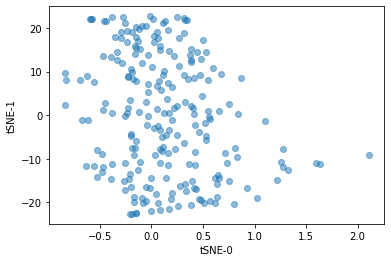

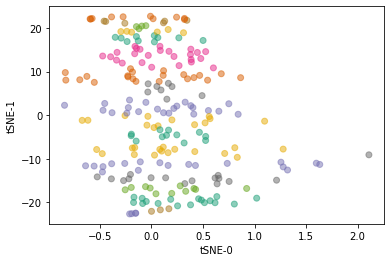

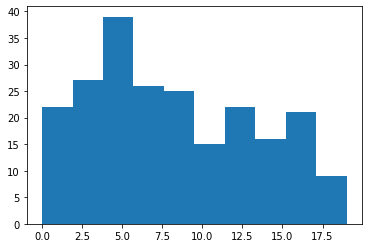

In [10]:
embed_dict_path = "/home/codex_analysis/codex-analysis/code/sampled_inference_z_embeds.obj"
kmeans_model = fit_clustering(embed_dict_path, K=20)

# Visualize a single image
With cluster labels, we can get a better view of the model embeddings. Let's take a look at "normal_045"

Z shape: 110 110 128


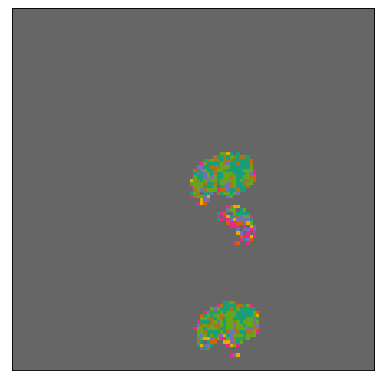

In [11]:
Z_path = "/home/data/tinycam/train/Zs/Z-tumor_045.npy"
visualize_Z(Z_path, kmeans_model)

Z shape: 110 110 128


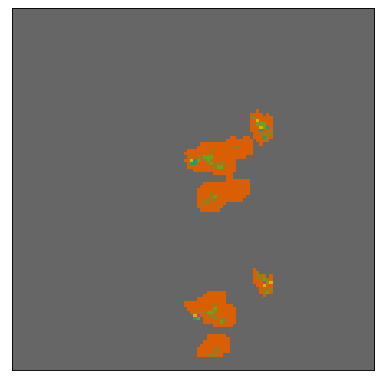

In [12]:
Z_path = "/home/data/tinycam/train/Zs/Z-normal_045.npy"
visualize_Z(Z_path, kmeans_model)

# Train on Zs
We have a few models we can train based on these Z data.

Those with in-situ explanation maps:
- ConvMixer/AttnMixer/S4Mixer/ViT-tiny on Z
- ConvMixer/AttnMixer/S4Mixer/ViT-tiny on Z's cluster labels

Baseline classifiers without explanation maps:
- ElasticNet/XGBoost on meanpool Z
- ElasticNet/XGBoost on maxpool Z
- ElasticNet/XGBoost on cat(meanpool, maxpool) Z
- ElasticNet/XGBoost on normalized bag of clusters

In [13]:
Zs_path = "/home/data/tinycam/train/Zs"
n_normal, n_tumor = 0,0
for Z_file in os.listdir(Zs_path):
    no_ext = Z_file.split(".npy")[0]
    id_name = no_ext.split("-")[1]
    Z_class = id_name.split("_")[0]
    if Z_class == "normal":
        n_normal += 1
    else:
        n_tumor += 1

print("0 / 1 class cases:", n_normal, n_tumor)

0 / 1 class cases: 111 111


We want to create a mini-validation set to make sure we don't overfit models. Say, 10% of training, or 22 samples.

In [19]:
Zs_path = "/home/data/tinycam/train/Zs"
n_normal, n_tumor = 0,0
train_set = []
val_set = []
desired_per_class = 11

for Z_file in os.listdir(Zs_path):
    no_ext = Z_file.split(".npy")[0]
    id_name = no_ext.split("-")[1]
    Z_class = id_name.split("_")[0]
    if Z_class == "normal":
        if n_normal >= desired_per_class:
            train_set.append(Z_file)
        else:
            val_set.append(Z_file)
            n_normal += 1
    else: # tumor
        if n_tumor >= desired_per_class:
            train_set.append(Z_file)
        else:
            val_set.append(Z_file)
            n_tumor += 1

print("train / val split:", len(train_set), len(val_set))

train / val split: 200 22


Begin training!

In [29]:
from models import ConvMixer
import torch.optim as optim

In [41]:
dim, depth = 512, 20 #hidden dim, depthwise conv 
Zs_path = "/home/data/tinycam/train/Zs"

# ic=1
# m="clusterZ"

ic=128
m="fullZ"

adapter = ConvMixer(dim, depth, in_channels=ic, kernel_size=9, patch_size=7, n_classes=2)
optimizer = optim.Adam(adapter.parameters(), lr=1e-6)
model, train_losses, val_losses = train_on_Z(adapter, device, optimizer, Zs_path, label_dict_path, train_set, val_set, epochs=20, mode=m, kmeans_model=kmeans_model)

end of epoch 0 train loss: 0.6873723268508911
end of epoch 0 AVG train loss: 0.6909136389618489
end of epoch 0 AVG val loss: 1.1414798274636269

end of epoch 1 train loss: 0.737493634223938
end of epoch 1 AVG train loss: 0.6918365359306335
end of epoch 1 AVG val loss: 0.8502897098660469

end of epoch 2 train loss: 0.6947788596153259
end of epoch 2 AVG train loss: 0.6928266280919165
end of epoch 2 AVG val loss: 0.9755211509764194

end of epoch 3 train loss: 0.7508894801139832
end of epoch 3 AVG train loss: 0.6933235176908437
end of epoch 3 AVG val loss: 0.7798816189169884

end of epoch 4 train loss: 0.6009801626205444
end of epoch 4 AVG train loss: 0.6915816856853998
end of epoch 4 AVG val loss: 1.0698085613548756

end of epoch 5 train loss: 0.6925703287124634
end of epoch 5 AVG train loss: 0.6902725168721593
end of epoch 5 AVG val loss: 0.7995151653885841

end of epoch 6 train loss: 0.6947612762451172
end of epoch 6 AVG train loss: 0.68970716978187
end of epoch 6 AVG val loss: 1.906105

--------------------------------------------------

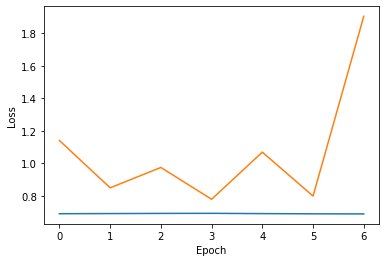

In [42]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Older Visualizations for single images

In [18]:
scope = ["normal_045"] #["normal_045", "normal_068", "tumor_033", "tumor_077"]
model_path = "/home/codex_analysis/codex-analysis/models/cam/ResNet18-hdf5_triplets_random_loading-224-label_selfsup-custom_loss-on_cam-cam16-filtration_background_epoch1.pt"
embed_dict = inference_z(model_path, patch_dir, scope=scope)

GPU detected? False

Note: gpu NOT available!
We have 192618 unique patches to embed
loading model for inference...
Specifically embedding for data: ['normal_045']


In [19]:
import utils
utils.serialize(embed_dict, "inference_z_embeds.obj")

total embeds: (1137, 128)
(1137, 2)
Z is of size: [102, 47]


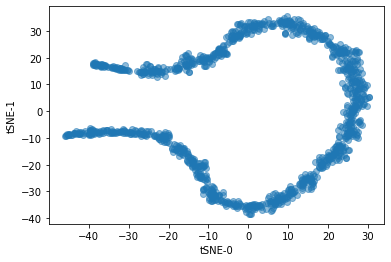

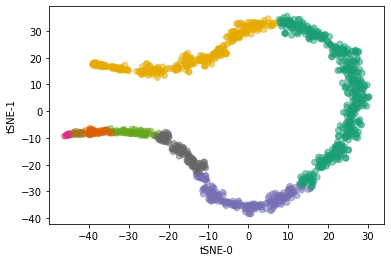

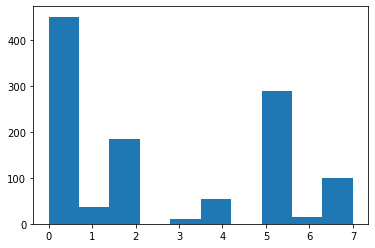

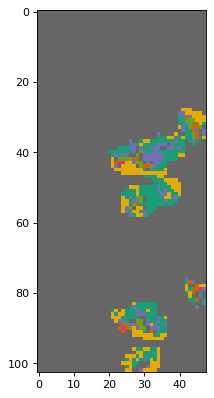

[[8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 ...
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]
 [8. 8. 8. ... 8. 8. 8.]]


In [47]:
embed_dict_path = "inference_z_embeds.obj"
visualize_z(embed_dict_path, dim_dict, scope=scope)